In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

**Loading Datasets: Train, Test, Sample Submission**

In [2]:
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC # This is the SVM classifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
df = pd.read_csv("train.csv").drop(columns = ['PassengerId', 'Name'])
test_df = pd.read_csv("test.csv").drop(columns = ['PassengerId', 'Name'])
sample = pd.read_csv("sample_submission.csv")
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [4]:
sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


**Data Visualization**

In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


In [7]:
#determine distribution for destinations
df['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

Text(0.5, 1.0, 'Age Count Distribution')

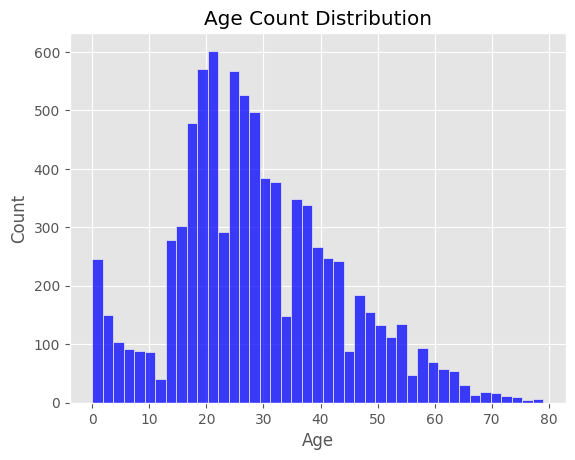

In [8]:
sns.histplot(df['Age'], color='b');
plt.title("Age Count Distribution")

Text(0.5, 1.0, 'Value Counts for Transported Passengers')

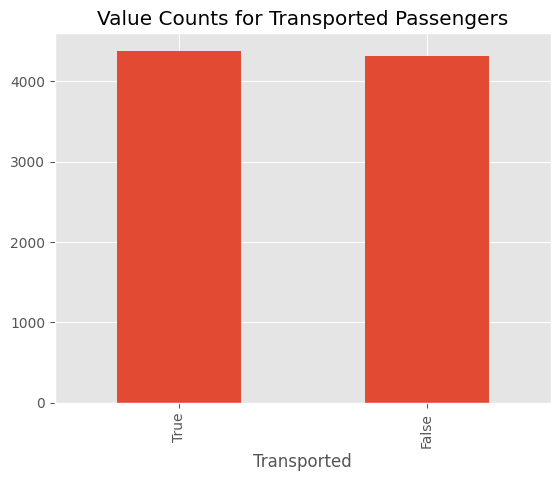

In [9]:
plot_df = df.Transported.value_counts()
plot_df.plot(kind="bar")

plt.title("Value Counts for Transported Passengers")

In [10]:
# features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
# plots = []

# for col in features:
#     temp = pd.concat([df[col], test_df[col]], axis=0)
#     le = LabelEncoder().fit(temp)
#     df[col] = le.transform(df[col])
#     test_df[col] = le.transform(test_df[col])

# df_num = df[["HomePlanet", 'CryoSleep', 'Destination', 'Age']]
# df_num.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8);
# plt.show()

Data shows: \
Most passengers ransported came from Earth. \
Most passengers who were put in CryoSleep were transportes \
Of the transported passengers, the majority were headed to TRAPPIST 1-e.

**Data Cleaning and Splitting**

In [11]:
def preprocess(in_df):
    out = in_df
    # Split Cabin column into constituent parts
    out['Cabin_deck'] = [c[0] if isinstance(c, str) else pd.NA for c in out['Cabin']]
    out['Cabin_num'] = [float(c.split('/')[1]) if isinstance(c, str) else pd.NA for c in out['Cabin']]
    out['Cabin_side'] = [c[-1] if isinstance(c, str) else pd.NA for c in out['Cabin']]
    out.drop('Cabin', axis=1, inplace=True)

    # Numericize categorical columns
    out = pd.get_dummies(out, columns=['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side'], dtype=float, dummy_na=True)

    # Standardize column types
    out = out.astype(pd.Float32Dtype)

    # Fill NA values with column means
    for col in out:
        if 'nan' in col:
            slug = '_'.join(col.split('_')[:-1]) + '_'
            dummy_nans = out[col].astype(bool)

            for target_col in out:
                if slug not in target_col:
                    continue
                out.loc[dummy_nans, target_col] = out[target_col].mean()

            out.drop(col, axis=1, inplace=True)

        else:
            out[col].fillna(value=out[col].mean(), inplace=True)
    
    return out

In [12]:
df = preprocess(df)
test_df = preprocess(test_df)

C:\Users\xkcdb\AppData\Local\Temp\ipykernel_17560\3504469966.py:13: UserWarning: Instantiating Float32Dtype without any arguments.Pass a Float32Dtype instance to silence this warning.
  out = out.astype(pd.Float32Dtype)
C:\Users\xkcdb\AppData\Local\Temp\ipykernel_17560\3504469966.py:13: UserWarning: Instantiating Float32Dtype without any arguments.Pass a Float32Dtype instance to silence this warning.
  out = out.astype(pd.Float32Dtype)


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.drop('Transported', axis = 1), df['Transported'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier()
params = {'alpha': 10.0 ** -np.arange(1, 7),
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
          'random_state': [42]}

# n_jobs=-1 parallelizes with every available thread. Change it to 1 if it murders your computer.
gcv = GridSearchCV(estimator=mlp, param_grid=params, n_jobs=-1)
gcv.fit(X_train, y_train)
model = gcv.best_estimator_

model.score(X_test, y_test)

C:\Users\xkcdb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8178472861085556

In [14]:
#feature selection

# corr_mat = df.corr()

# f, ax = plt.subplots(figsize=(13, 10))
# sns.heatmap(corr_mat, vmax=.8, square=True)
